In [105]:
%matplotlib inline

In [106]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [107]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [108]:
def mnist_reshape_128(x, i_offset = 0, j_offset = 0):
    assert x.shape == (28 * 28,)
    image = x.reshape(28, 28)
    image = np.append(np.zeros((128 + 2, 28)), image, axis = 0)
    image = np.append(image, np.zeros((128 + 2, 28)), axis = 0)
    image = np.append(np.zeros((288, 128 + 2)), image, axis = 1)
    image = np.append(image, np.zeros((288, 128 + 2)), axis = 1)
    return image[128 + 16 - 64 - i_offset : 128 + 16 + 64 - i_offset, 128 + 16 - 64 - j_offset : 128 + 16 + 64 - j_offset]

def minmax(value,   #valeur a delimiter
           border): #limite min/max a ne pas depasser 
    value = max(value, -border)
    value = min(value, border)
    return value

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def softmax_label_to_value(softmax_label):
    y_num = 0
    for n in softmax_label:
        if n == np.max(softmax_label): 
            value = y_num
            break
        y_num += 1
    return value  

def one_hot_label_to_value(one_hot_label):
    y_num = 0
    for n in one_hot_label:
        if n == 1: 
            value = y_num
            break
        y_num += 1
    return value  

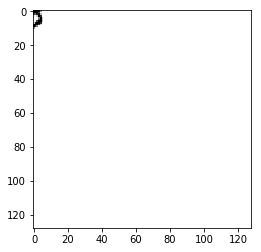

In [51]:
mnist_image_sample = mnist_reshape_128(mnist.train.images[5], -64, -64)
plt.imshow(mnist_image_sample, cmap= 'gray_r')

# Learning a classifier

In [12]:
batch_size = 4000
iterations = 1600
alpha = 0.1
vector_size = 128*128

In [13]:
weights = tf.Variable(tf.random_normal([vector_size,10], stddev=0.1), name='weights')
x_train = tf.placeholder(tf.float32, shape=[None,vector_size], name='t_train')
labels = tf.placeholder(tf.float32, shape=[None,10], name='labels')

In [14]:
sess = tf.Session()

In [15]:
hypo = tf.nn.softmax(tf.matmul(x_train, weights))
cost = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=hypo)
optimizer = tf.train.AdamOptimizer(alpha).minimize(cost)
saver = tf.train.Saver(var_list={"weights": weights})

init = tf.global_variables_initializer()
sess.run(init)

In [16]:
for it in range(iterations):
    batch = mnist.test.next_batch(batch_size)
    x_list, label_list = [],[]
    count_example = 0
    for example in batch[0]:
        i_off, j_off = minmax(int(np.random.randn() * 0),0), minmax(int(np.random.randn() * 0),0)
        image = mnist_reshape_128(example, i_off, j_off)
        x_list += [np.ravel(image)]
        label_list += [batch[1][count_example]]
        count_example += 1
        
    sess.run(optimizer, {x_train: x_list, labels: label_list})
    saver.save(sess, "/home/pimt/Documents/Notebooks/classifier_weights.ckpt")
    
    if it%100==0: print(it,'/',iterations)

0 / 1600
100 / 1600
200 / 1600
300 / 1600
400 / 1600
500 / 1600
600 / 1600
700 / 1600
800 / 1600
900 / 1600
1000 / 1600
1100 / 1600
1200 / 1600
1300 / 1600
1400 / 1600
1500 / 1600


In [17]:
sess.close()

# Evaluating the classifier

In [109]:
eval_batch_size = 1000
conf_batch_size = 10
iterations = 100
N_pic = 128
vector_size = N_pic*N_pic

### Data restoration

In [22]:
tf.reset_default_graph()
sess = tf.Session()
weights = tf.Variable(tf.random_normal([vector_size,10], stddev=0.1), name='weights')
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(sess, "/home/pimt/Documents/Notebooks/classifier_weights.ckpt")

weights_values = weights.eval(session=sess)
print(weights_values)

INFO:tensorflow:Restoring parameters from /home/pimt/Documents/Notebooks/classifier_weights.ckpt


INFO:tensorflow:Restoring parameters from /home/pimt/Documents/Notebooks/classifier_weights.ckpt


[[ 0.12925439  0.20908009  0.09924848 ...,  0.09835599  0.07866054
  -0.08189608]
 [ 0.11676731 -0.13189325 -0.01618153 ...,  0.02987286 -0.06662248
  -0.01956053]
 [-0.04790026  0.01891794  0.12668549 ..., -0.12608975  0.12223919
   0.10818677]
 ..., 
 [-0.0254373   0.03657627 -0.12741911 ...,  0.02566993  0.05265822
   0.03628525]
 [ 0.11103028  0.07526372 -0.02555583 ...,  0.07254429  0.02233324
   0.04577034]
 [ 0.23786429 -0.00047854  0.15811615 ..., -0.0755329   0.07151483
   0.09004939]]


### Evaluation

In [23]:
correct_numb = 0
for it in range(iterations):
    eval_batch = mnist.test.next_batch(eval_batch_size)
    example_numb = 0
    for example in eval_batch[0]:
        i_off, j_off = minmax(int(np.random.randn() * 0),4), minmax(int(np.random.randn() * 0),4)
        image = mnist_reshape_128(example, i_off, j_off)
        cat_off = eval_batch[1][example_numb]
        cat_hat = softmax(np.dot(np.ravel(image), weights_values))
        if one_hot_label_to_value(cat_off) == softmax_label_to_value(cat_hat):
            correct_numb += 1
        example_numb += 1
    if it%25 == 0: print(it,'/',iterations)
percent_correct = (correct_numb*100)/(iterations*eval_batch_size)
print(percent_correct,'%')

0 / 100
25 / 100
50 / 100
75 / 100
97.026 %


### Building the confidence graph

In [93]:
hit = np.zeros((N_pic,N_pic))
num_i = 0
for i_off in range(-(N_pic//2),(N_pic//2),1):
    num_j = 0
    for j_off in range(-(N_pic//2),(N_pic//2),1):
        if num_i%10==0 and num_j%50==0: print('(i,j) =',num_i,num_j)
        conf_batch = mnist.test.next_batch(conf_batch_size)
        example_numb, correct_numb = 0,0
        for example in conf_batch[0]:
            image = mnist_reshape_128(example, i_off, j_off)
            cat_off = conf_batch[1][example_numb]
            cat_hat = softmax(np.dot(np.ravel(image), weights_values))
            if one_hot_label_to_value(cat_off) == softmax_label_to_value(cat_hat):
                correct_numb += 1
            example_numb += 1
        hit[num_i][num_j] = (correct_numb/conf_batch_size)
        num_j += 1
    num_i += 1
    
np.save("Classifer_accuracy.npy", hit)

(i,j) = 0 0
(i,j) = 0 50
(i,j) = 0 100
(i,j) = 10 0
(i,j) = 10 50
(i,j) = 10 100
(i,j) = 20 0
(i,j) = 20 50
(i,j) = 20 100
(i,j) = 30 0
(i,j) = 30 50
(i,j) = 30 100
(i,j) = 40 0
(i,j) = 40 50
(i,j) = 40 100
(i,j) = 50 0
(i,j) = 50 50
(i,j) = 50 100
(i,j) = 60 0
(i,j) = 60 50
(i,j) = 60 100
(i,j) = 70 0
(i,j) = 70 50
(i,j) = 70 100
(i,j) = 80 0
(i,j) = 80 50
(i,j) = 80 100
(i,j) = 90 0
(i,j) = 90 50
(i,j) = 90 100
(i,j) = 100 0
(i,j) = 100 50
(i,j) = 100 100
(i,j) = 110 0
(i,j) = 110 50
(i,j) = 110 100
(i,j) = 120 0
(i,j) = 120 50
(i,j) = 120 100


In [110]:
filepath = "Classifer_accuracy.npy"
if os.path.isfile(filepath):
    hit = np.load(filepath)
print(hit)

[[ 0.1  0.   0.2 ...,  0.1  0.2  0.2]
 [ 0.1  0.   0.1 ...,  0.1  0.   0.1]
 [ 0.2  0.2  0.1 ...,  0.   0.   0.3]
 ..., 
 [ 0.   0.1  0.  ...,  0.   0.2  0.1]
 [ 0.   0.   0.1 ...,  0.   0.3  0.3]
 [ 0.   0.1  0.  ...,  0.1  0.   0.1]]


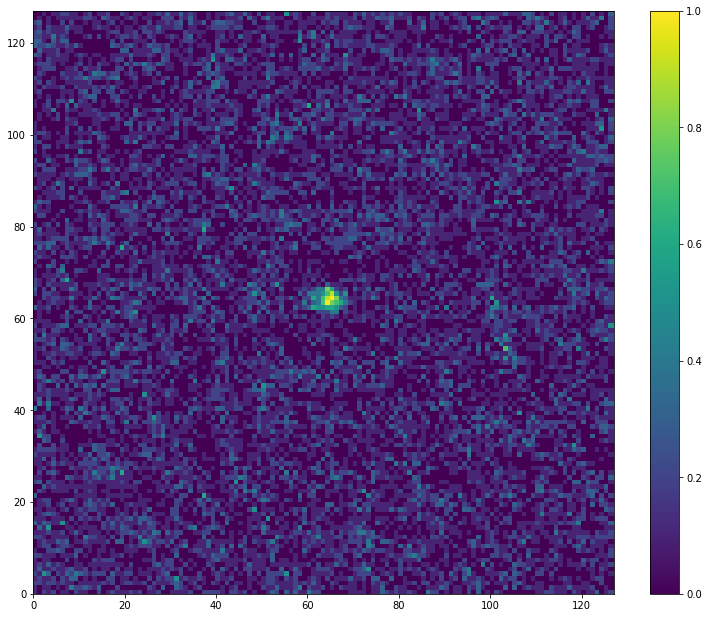

In [99]:
fig, ax = plt.subplots(figsize=(13,10.725))
#cmap = ax.pcolor(np.arange(-N_pic/2, N_pic/2), np.arange(-N_pic/2, N_pic/2), hit)
cmap = ax.pcolor(np.arange(0, N_pic), np.arange(0, N_pic), hit)
ax.axis('equal')
fig.colorbar(cmap)